A basic RNN model predicts movement quality scores obtained using GMM loglikelihood for the between-subject case. The input to the network are raw measurement data with 117 dimensions.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

In [2]:
timesteps = 240 # Number of timesteps
nr = 90   # Number of repetitions
n_dim = 117  # Dimension of data sequences
dropout_rate = 0.2   # Droput rate

In [3]:
# Function to load the data
def load_data(nr, n_dim, timesteps):
    f = open('../../Data/Data_Correct.csv')
    csv_f = csv.reader(f)
    Correct_X = list(csv_f)

    # Convert the input sequences into numpy arrays
    train_input1 = np.asarray(Correct_X, dtype = float)
    correct_input = np.zeros((nr,timesteps,n_dim))
    for i in range(len(train_input1)//n_dim):
           correct_input[i,:,:] = np.transpose(train_input1[n_dim*i:n_dim*(i+1),:])
    
    f = open('../../Data/Labels_Correct.csv')
    csv_f = csv.reader(f)
    Correct_Y = list(csv_f)
    
    # Convert the input labels into numpy arrays
    correct_label = np.asarray(Correct_Y, dtype = float)
    
    f = open('../../Data/Data_Incorrect.csv')
    csv_f = csv.reader(f)
    Incorrect_X = list(csv_f)

    # Convert the input sequences into numpy arrays
    test_input1 = np.asarray(Incorrect_X)
    n_dim = 117
    incorrect_input = np.zeros((nr,timesteps,n_dim))
    for i in range(len(test_input1)//n_dim):
          incorrect_input[i,:,:] = np.transpose(test_input1[n_dim*i:n_dim*(i+1),:])
            
    f = open('../../Data/Labels_Incorrect.csv')
    csv_f = csv.reader(f)
    Incorrect_Y = list(csv_f)
    
    # Convert the input labels into numpy arrays
    incorrect_label = np.asarray(Incorrect_Y, dtype = float)
    
    return correct_input, correct_label, incorrect_input, incorrect_label

In [4]:
# Load the data
Correct_data, Correct_label, Incorrect_data, Incorrect_label = load_data(nr, n_dim, timesteps)

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [5]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# Sample random indices
trainidx1 = random.sample(range(0,Correct_data.shape[0]),int(nr*0.7))
trainidx2 = random.sample(range(0,Incorrect_data.shape[0]),int(nr*0.7))
valididx1 = np.setdiff1d(np.arange(0,nr,1),trainidx1)
valididx2 = np.setdiff1d(np.arange(0,nr,1),trainidx2)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


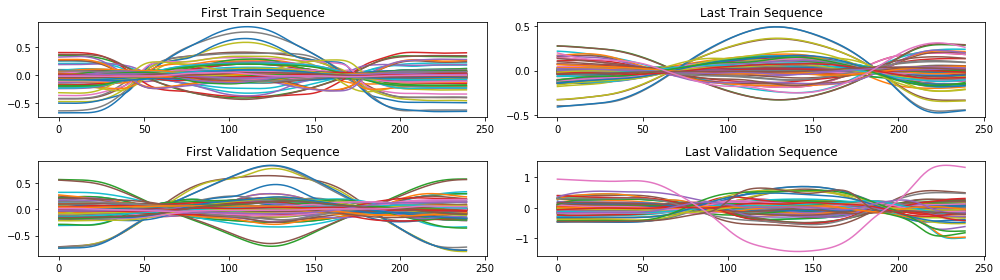

In [6]:
# Plot the first and last sequence in the training and validation data
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [7]:
# Build RNN model ...
def Network():
    model = Sequential()

    model.add(Bidirectional(LSTM(20, recurrent_dropout = 0.5, return_sequences = True), input_shape = (timesteps,n_dim)))
    model.add(Dropout(0.25))

    model.add(Dense(30, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    #model.summary()
    
    # Measure the training time and implement early stoping
    t = now()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    history = model.fit(train_x, train_y, batch_size=10, epochs=5000, verbose=0, 
                         validation_data=(valid_x, valid_y),
                         callbacks = [early_stopping])
    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the RNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.ylim([-0.1,1.1])
    plt.title('Training Set',fontsize=18)
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Scale',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.subplot(2,1,2)
    plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.title('Testing Set',fontsize=18)
    plt.ylim([-0.1,1.1])
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Scale',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.tight_layout()
    plt.savefig('../../Results/RNN_Vicon_Scores.png', dpi=300)
    plt.show()
        
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-np.squeeze(valid_y))
    mean_abs_dev = np.mean(test_dev)
    print('mean absolute deviation', mean_abs_dev)

    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('rms deviation', rms_dev)
    
    return mean_abs_dev, rms_dev





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training time: 0:48:33.323102


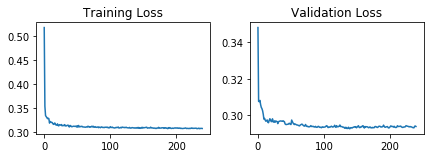

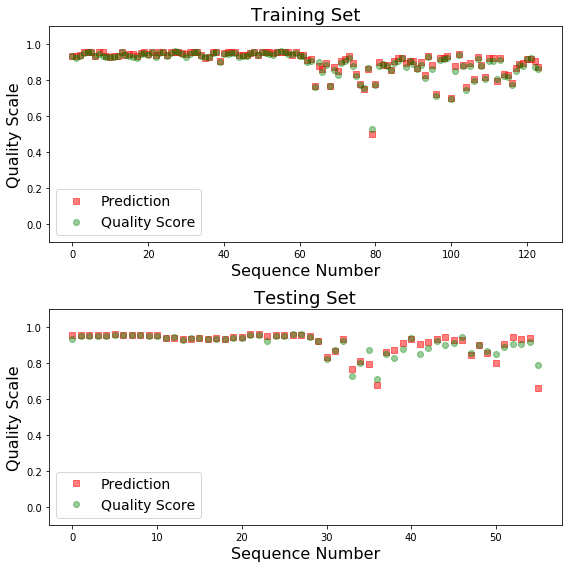

mean absolute deviation 0.016236651045254295
rms deviation 0.02732665462849751


In [8]:
Mean_abs_dev, RMS_dev  = Network() 